In [1]:
import os
import sys
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

In [2]:
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class ConvBlock(nn.Module):
    def __init__(self, in_filters, out_filters, kernel_size=3, batchnorm=True, last_activ=F.relu):
        super(ConvBlock, self).__init__()
        self.bn = batchnorm
        self.last_activ = last_activ
        self.c1 = nn.Conv2d(in_filters, out_filters, kernel_size, padding=1)
        self.b1 = nn.BatchNorm2d(out_filters)
        self.c2 = nn.Conv2d(out_filters, out_filters, kernel_size, padding=1)
        self.b2 = nn.BatchNorm2d(out_filters)
    def forward(self, x):
        x = self.c1(x)
        if self.bn: x = self.b1(x)
        x = F.relu(x)
        x = self.c2(x)
        if self.bn: x = self.b2(x)
        x = self.last_activ(x)
        return x

In [4]:
class ContractiveBlock(nn.Module):
    def __init__(self, in_filters, out_filters, conv_kern=3, pool_kern=2, dropout=0.5, batchnorm=True):
        super(ContractiveBlock, self).__init__()
        self.c1 = ConvBlock(in_filters=in_filters, out_filters=out_filters, kernel_size=conv_kern, batchnorm=batchnorm)
        self.p1 = nn.MaxPool2d(kernel_size=pool_kern)
        self.d1 = nn.Dropout2d(dropout)
    def forward(self, x):
        c = self.c1(x)
        return c, self.d1(self.p1(c))

In [5]:
class ExpansiveBlock(nn.Module):
    def __init__(self, in_filters1, in_filters2, out_filters, tr_kern=3, conv_kern=3, stride=2, dropout=0.5):
        super(ExpansiveBlock, self).__init__()
        self.t1 = nn.ConvTranspose2d(in_filters1, out_filters, tr_kern, stride=2, padding=1, output_padding=1)
        self.d1 = nn.Dropout(dropout)
        self.c1 = ConvBlock(out_filters+in_filters2, out_filters, conv_kern)
        
    def forward(self, x, contractive_x):
        x_ups = self.t1(x)
        x_concat = torch.cat([x_ups, contractive_x], 1)
        x_fin = self.c1(self.d1(x_concat))
        return x_fin

In [6]:
class Unet(nn.Module):
    def __init__(self, n_labels, n_filters=16, p_dropout=0.5, batchnorm=True):
        super(Unet, self).__init__()
        filter_dict = {}
        filt_pair = [3, n_filters]
        
        for i in range(4):
            self.add_module('contractive_'+str(i), ContractiveBlock(filt_pair[0], filt_pair[1], batchnorm=batchnorm))
            filter_dict['contractive_'+str(i)] = (filt_pair[0], filt_pair[1])
            filt_pair[0] = filt_pair[1]
            filt_pair[1] = filt_pair[1] * 2
        
        self.bottleneck = ConvBlock(filt_pair[0], filt_pair[1], batchnorm=batchnorm)
        filter_dict['bottleneck'] = (filt_pair[0], filt_pair[1])
        
        for i in reversed(range(4)):
            self.add_module('expansive_'+str(i), ExpansiveBlock(filt_pair[1], filter_dict['contractive_'+str(i)][1], filt_pair[0]))
            filter_dict['expansive_'+str(i)] = (filt_pair[1], filt_pair[0])
            filt_pair[1] = filt_pair[0]
            filt_pair[0] = filt_pair[0] // 2
        
        self.output = nn.Conv2d(filt_pair[1], n_labels, kernel_size=1)
        filter_dict['output'] = (filt_pair[1], n_labels)
        self.filter_dict = filter_dict
    
    def forward(self, x):
        c00, c0 = self.contractive_0(x)
        c11, c1 = self.contractive_1(c0)
        c22, c2 = self.contractive_2(c1)
        c33, c3 = self.contractive_3(c2)
        bottle = self.bottleneck(c3)
        u3 = F.relu(self.expansive_3(bottle, c33))
        u2 = F.relu(self.expansive_2(u3, c22))
        u1 = F.relu(self.expansive_1(u2, c11))
        u0 = F.relu(self.expansive_0(u1, c00))
        return F.softmax(self.output(u0), dim=1)
        

In [82]:
net = Unet(2).cuda()

In [83]:
from PIL import Image

In [84]:
class TSegLoader(torch.utils.data.Dataset):
    def __init__(self, image_folder, mask_folder):
        self.images = os.listdir(image_folder)
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.tx = torchvision.transforms.Compose([
#             torchvision.transforms.Resize((256,256)),
            torchvision.transforms.ToTensor()
        ])
        
        self.mx = torchvision.transforms.Compose([
            torchvision.transforms.Grayscale(),
#             torchvision.transforms.Resize((256,256)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Lambda(lambda x : torch.cat([x,1-x], dim=0))
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, i):
        i1 = Image.open(self.image_folder + self.images[i])
        m1 = Image.open(self.mask_folder + self.images[i])
        
        return self.tx(i1), self.mx(m1)

In [85]:
tr = torch.utils.data.DataLoader(TSegLoader('training/','manual/'), batch_size=4, shuffle=True)

In [86]:
opt = torch.optim.Adam(net.parameters())

0 75.5618980973959
1 57.25850007683039
2 55.95494296774268
3 55.291290771216154
4 54.79730314388871
5 54.45556716620922
6 53.99870187602937
7 53.5640972815454
8 53.045842967927456
9 52.438719511032104


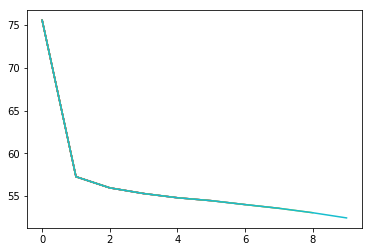

In [87]:
loss_history = []
for i in range(10):
    train_loss = 0.0
    for x, y in tr:
        x, y = x.cuda(),y.cuda()
        opt.zero_grad()
        y_pred = net(x)
        loss = F.mse_loss(y_pred, y)
        train_loss +=loss.item()
        loss.backward()
        opt.step()   
    print (i,train_loss)
    loss_history.append(train_loss)
plt.plot(loss_history)

In [88]:
torch.save(net.state_dict(), 'test.pth')

In [89]:
net.filter_dict

{'contractive_0': (3, 16),
 'contractive_1': (16, 32),
 'contractive_2': (32, 64),
 'contractive_3': (64, 128),
 'bottleneck': (128, 256),
 'expansive_3': (256, 128),
 'expansive_2': (128, 64),
 'expansive_1': (64, 32),
 'expansive_0': (32, 16),
 'output': (16, 2)}

In [ ]:
net.load_state_dict(torch.l)

In [90]:
data_tranform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

In [125]:
image_id = str(np.random.randint(0,1000))
im = Image.open('training/' + image_id  + '_orig.jpg')
im_noise = Image.open('training/' + image_id  + '_noise.jpg')

s = data_tranform(im).unsqueeze(0)
s = torch.cat((s,data_tranform(im_noise).unsqueeze(0)))

pred= net(s.cuda()).cpu()
# pred = pred.detach().numpy()

f = plt.figure()
f.add_subplot(2,2, 1)
plt.imshow(im)
f.add_subplot(2,2, 2)
plt.imshow(im_noise)
f.add_subplot(2,2, 3)
plt.imshow(pred[0][0],cmap='gray')
f.add_subplot(2,2, 4)
plt.imshow(pred[1][0],cmap='gray')


RuntimeError: CUDA error: unspecified launch failure

In [116]:
def digitize(x):
    if x>0.5:
        return 1.
    else:
        return 0.
digitize = np.vectorize(digitize)

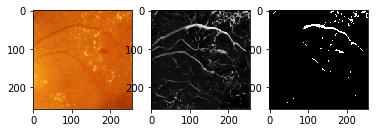

In [123]:
im = Image.open('diabetic-retinopathy-header.jpg')
im = np.asarray(im)
im = im[200:456,400:656]
s = data_tranform(im)
pred= net(s.unsqueeze(0).cuda()).cpu()
pred = pred.detach().numpy()

f = plt.figure()
a = f.add_subplot(1,3, 1)
plt.imshow(im)
f.add_subplot(1,3, 2)
plt.imshow(pred[0][0],cmap='gray')
pred_cure = digitize(pred[0][0])
f.add_subplot(1,3, 3)
plt.imshow(pred_cure,cmap='gray')

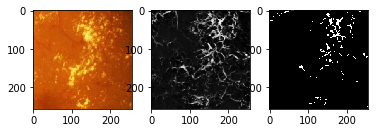

In [124]:
im = Image.open('diabetic-retinopathy-header.jpg')
im = np.asarray(im)
im = im[200:456,600:856]
s = data_tranform(im)
pred= net(s.unsqueeze(0).cuda()).cpu()
pred = pred.detach().numpy()

f = plt.figure()
a = f.add_subplot(1,3, 1)
plt.imshow(im)
f.add_subplot(1,3, 2)
plt.imshow(pred[0][0],cmap='gray')
pred_cure = digitize(pred[0][0])
f.add_subplot(1,3, 3)
plt.imshow(pred_cure,cmap='gray')